<a href="https://colab.research.google.com/github/YamenHabib/DeepLearning/blob/main/Adversarial_Attack_on_MNIST_corrected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets,transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

In [2]:
basepath = '/content/drive/MyDrive/data/MNIST2'
transform = transforms.ToTensor()
train_data = datasets.MNIST(root=basepath, train=True, download=False, transform=transform)
test_data = datasets.MNIST(root=basepath, train=False, download=False, transform=transform)

In [3]:
train_loader = DataLoader(train_data, batch_size = 256, shuffle=True)
test_loader = DataLoader(test_data, batch_size = 256, shuffle=False)

In [4]:
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

In [5]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [6]:
model = LeNet().to(device)

In [7]:
def epoch(loader, model, opt=None):
    total_loss = 0.
    for X,y in loader:
        X,y = X.to(device).float(), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
          opt.zero_grad()
          loss.backward()
          opt.step()
        total_loss += loss.item() * X.shape[0]
    return total_loss / len(loader.dataset)

In [8]:
model = LeNet().to(device)

In [9]:
optimizer = optim.SGD(model.parameters(), lr=1e-1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
for t in range(10):
    train_loss = epoch(train_loader, model, optimizer)
    test_loss = epoch(test_loader, model)
    scheduler.step()
    print("Train Loss: {}, Test Loss: {}".format(train_loss, test_loss))

Train Loss: 1.3329543532689412, Test Loss: 0.5619660516262055
Train Loss: 0.47182446522712707, Test Loss: 0.3765168043375015
Train Loss: 0.35714580569267274, Test Loss: 0.3414377946972847
Train Loss: 0.3116528652826945, Test Loss: 0.2715012156009674
Train Loss: 0.2742204418818156, Test Loss: 0.24924929461479187
Train Loss: 0.24857333761056263, Test Loss: 0.238193519577384
Train Loss: 0.24093846744696298, Test Loss: 0.22388833953738213
Train Loss: 0.23942639536857604, Test Loss: 0.2193327550828457
Train Loss: 0.23607665311495463, Test Loss: 0.22047580078840257
Train Loss: 0.23493061790466307, Test Loss: 0.21862088949680328


In [10]:
X_actual,y_actual = next(iter(test_loader))

In [11]:
def plot_images(X, y_a, y_p, M, N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(1.2*N,1.5*M))
    cnt = 0
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(X[cnt][0],cmap="gray")
            title = ax[i][j].set_title("a:{}, p:{}".format(y_a[cnt].item(),y_p[cnt].max(0, keepdim=True)[1].item()))
            plt.setp(title, color=('g' if y_p[cnt].max(0, keepdim=True)[1].item()==y_a[cnt].item() else 'r'))
            ax[i][j].set_axis_off()
            cnt+=1
    plt.tight_layout()

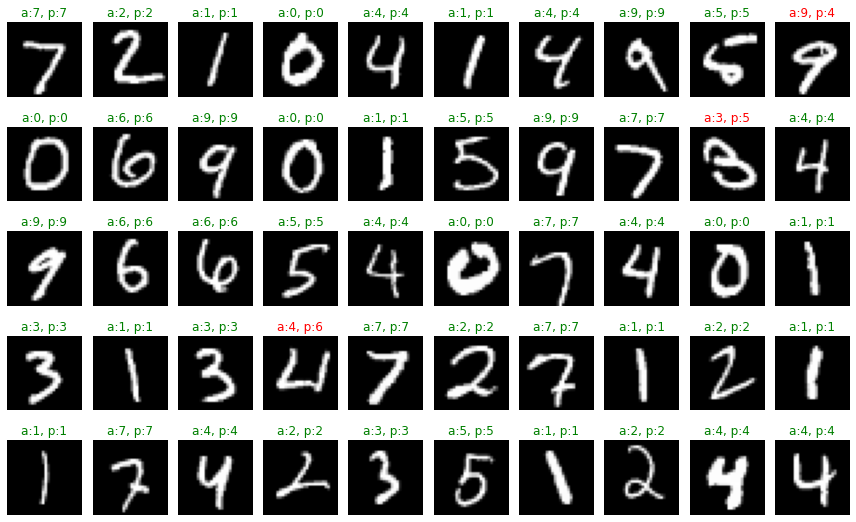

In [12]:
y_pred = model(X_actual.float())
plot_images(X_actual, y_actual, y_pred, 5, 10)

In [13]:
def fgsm(model, images, labels, epsilon):
    images.requires_grad = True
    loss = nn.CrossEntropyLoss()(model(images), labels)
    loss.backward()
    images_grad = images.grad.data
    sign_grad = images_grad.sign()
    perturbed_images = images + epsilon*sign_grad
    perturbed_images = torch.clamp(perturbed_images, 0, 1)
    return perturbed_images

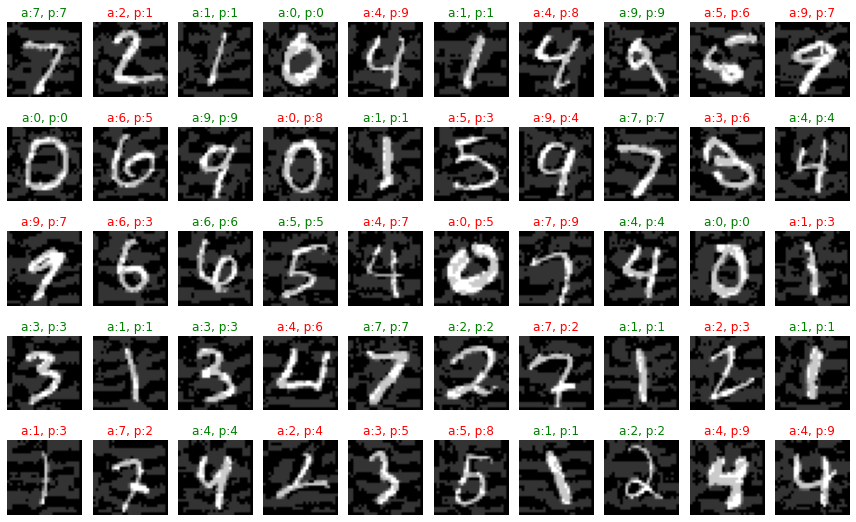

In [14]:
### Illustrate attacked images
perturbed_X = fgsm(model, X_actual.float(), y_actual, 0.2)
y_pred = model(perturbed_X.float())
perturbed_X = perturbed_X.detach().cpu().numpy()
#perturbed_X.requires_grad = False
plot_images(perturbed_X, y_actual, y_pred, 5, 10)

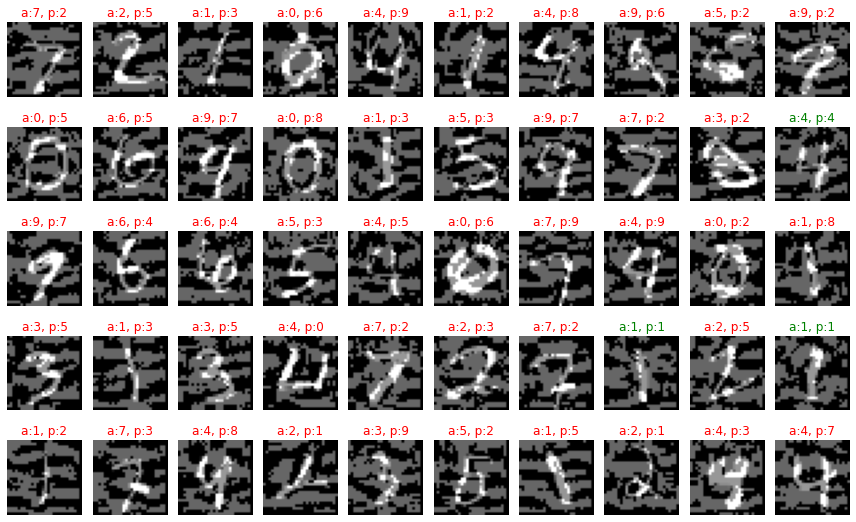

In [15]:
### Illustrate attacked images
perturbed_X = fgsm(model, X_actual.float(), y_actual, 0.4)
y_pred = model(perturbed_X.float())
perturbed_X = perturbed_X.detach().cpu().numpy()
#perturbed_X.requires_grad = False
plot_images(perturbed_X, y_actual, y_pred, 5, 10)